In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from exp.nb_Tesis import *
from fastai import *

# Download & Load Data

In [2]:
# !wget https://challenge.kitware.com/api/v1/item/584ad09dcad3a51cc66c8e15/download

In [3]:
# !wget https://challenge.kitware.com/api/v1/item/5849dadccad3a51cc66c8e08/download

In [4]:
path_all_images = Path('./2017/data/')

In [5]:
# name_folder_train = 'ISIC-2017_Training_Data'
# name_folder_valid = 'ISIC-2017_Validation_Data'

name_folder_train = 'train_small_224'
name_folder_valid = 'valid_small_224'


path_train_images = path_all_images / name_folder_train
path_valid_images = path_all_images / name_folder_valid

In [6]:
path_train_ground_truth = Path('2017/train_gt.csv')
path_valid_ground_truth = Path('2017/valid_gt.csv')

# path_test_images = Path('segmented_images/square/ISIC2018_Task3_Test_Input/')

In [7]:
dfTrain = pd.read_csv(path_train_ground_truth); print(f'{len(dfTrain)} train images: ')
dfValid = pd.read_csv(path_valid_ground_truth); print(f'{len(dfValid)} valid images: ')

dfAll = pd.concat([dfTrain,dfValid])

dfSingleLabel = pd.DataFrame({'image_id':dfAll['image_id'] })
dfSingleLabel['label'] = pd.np.where(dfAll['melanoma']==1.0, 'mel','other')
dfSingleLabel.head()

2000 train images: 
150 valid images: 


,image_id,label
0,ISIC_0000000,other
1,ISIC_0000001,other
2,ISIC_0000002,mel
3,ISIC_0000003,other
4,ISIC_0000004,mel


In [8]:
dfSingleLabel.groupby('label').count()

,image_id
label,
mel,404
other,1746


In [9]:
labels_for_2017_live_challenge = ['melanoma', 'nv', 'seborrheic_keratosis']

def get_label_for_image_name(image_name):
  return list(dfSingleLabel.loc[dfSingleLabel['image_id']==image_name].label)[0]

def get_label_for_image_path(image_path): 
    return get_label_for_image_name(image_path.name[:-4])

In [10]:
get_label_for_image_path(Path('2017/ISIC-2017_Training_Data/ISIC_0000010.jpg'))

'other'

In [11]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [12]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [13]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

# Create Databunch

In [197]:
random_seed(42,True)
tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.6, max_lighting=.3,p_affine=1,max_warp=0.2)

data = ImageList.from_folder(path_all_images)\
.split_by_folder(train=name_folder_train, valid=name_folder_valid)\
.label_from_func(get_label_for_image_path)\
.transform(tfms, size=224)\
.databunch(bs=16)\
.normalize()

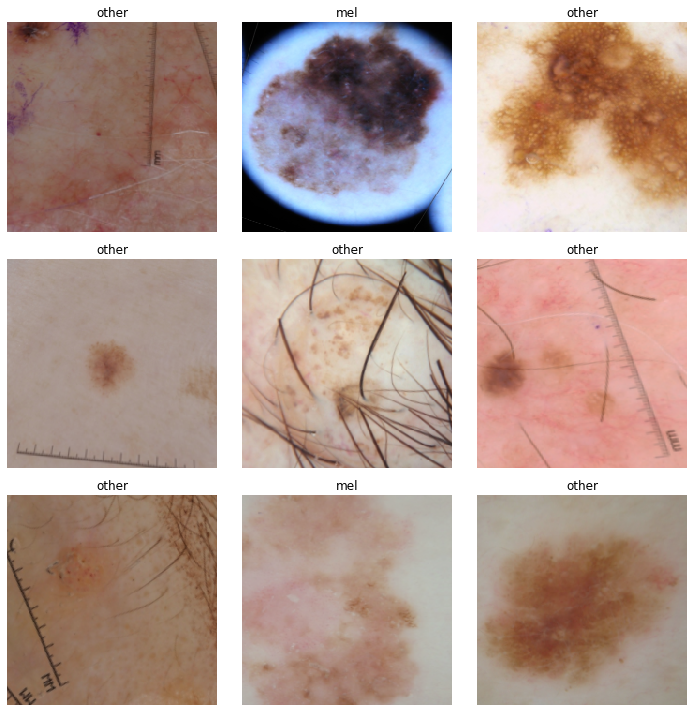

In [113]:
data.show_batch(rows=3, figsize=(10,10))

In [114]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print(train_count,'\n\n', valid_count)

other    1626
mel       374
dtype: int64 

 other    120
mel       30
dtype: int64


In [115]:
# del learn
# del data

torch.cuda.empty_cache()
gc.collect()

20075

# Create Learner

In [191]:
random_seed(7,True)
# x50 = lambda x: xresnet50()resnet14
learn = cnn_learner(data,models.resnet50, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ], 
                    
                    pretrained=True
                    )

In [118]:
# learn.load('bestmodel')
# learn.lr_find()

## Train model's head

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.160033,0.826486,0.246667,0.753333,0.645833,00:18
1,0.645415,0.726221,0.193333,0.806667,0.554167,00:17
2,0.499348,0.475260,0.186667,0.813333,0.734722,00:17
3,0.444049,0.429571,0.173333,0.826667,0.783611,00:17
4,0.394043,0.435819,0.173333,0.826667,0.782778,00:17


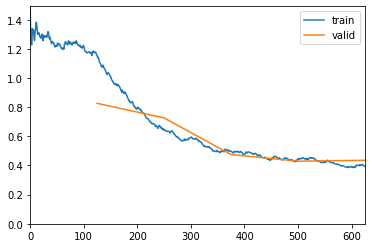

Better model found at epoch 0 with valid_loss value: 0.8264862298965454.
Better model found at epoch 1 with valid_loss value: 0.7262209057807922.
Better model found at epoch 2 with valid_loss value: 0.47526004910469055.
Better model found at epoch 3 with valid_loss value: 0.4295705258846283.
Epoch 4: reducing lr to 2.4e-09


In [17]:
random_seed(7,True)
learn.fit_one_cycle(5,max_lr=3e-3, callbacks = [
    SaveModelCallback(learn=learn),
    ReduceLROnPlateauCallback(learn=learn)
])

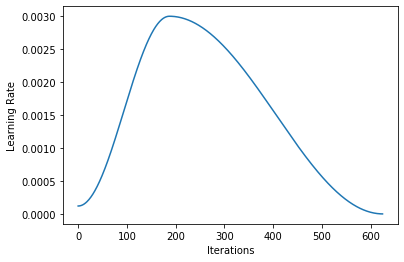

In [120]:
learn.recorder.plot_lr()

## Unfreeze & finetune

In [121]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1')

In [195]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.31E-05


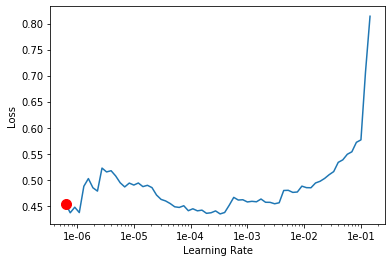

In [124]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

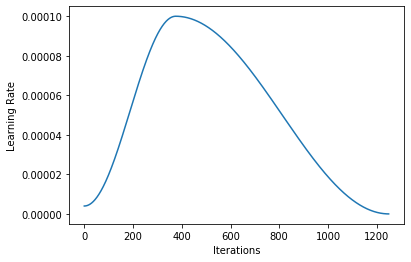

In [28]:
learn.recorder.plot_lr()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.190368,0.616931,0.306667,0.693333,0.680833,00:22
1,1.014481,0.566620,0.253333,0.746667,0.729444,00:22
2,0.896629,0.640905,0.286667,0.713333,0.712222,00:22
3,0.884975,0.638222,0.253333,0.746667,0.725000,00:22
4,0.708498,0.574985,0.213333,0.786667,0.718889,00:22
5,0.677257,0.877223,0.220000,0.780000,0.655556,00:22
6,0.566663,0.690895,0.186667,0.813333,0.736667,00:23
7,0.493571,0.522175,0.186667,0.813333,0.784722,00:22
8,0.471259,0.510524,0.186667,0.813333,0.801111,00:22
9,0.469959,0.604977,0.233333,0.766667,0.666667,00:22


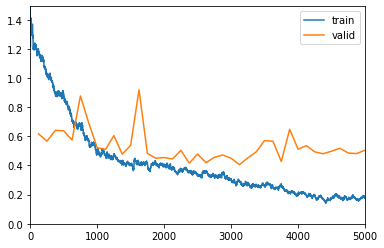

Better model found at epoch 0 with valid_loss value: 0.6169312000274658.
Better model found at epoch 1 with valid_loss value: 0.5666201710700989.
Better model found at epoch 7 with valid_loss value: 0.522174596786499.
Better model found at epoch 8 with valid_loss value: 0.5105236172676086.
Better model found at epoch 10 with valid_loss value: 0.47774210572242737.
Better model found at epoch 14 with valid_loss value: 0.4498182535171509.
Better model found at epoch 16 with valid_loss value: 0.4447227418422699.
Better model found at epoch 18 with valid_loss value: 0.41591623425483704.
Better model found at epoch 24 with valid_loss value: 0.405971497297287.


In [196]:
random_seed(7,True)
learn.fit_one_cycle(40, wd=1e-06, max_lr=slice(1e-05,1e-03),callbacks = [
    SaveModelCallback(learn=learn),
#     ReduceLROnPlateauCallback(learn=learn)
])

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

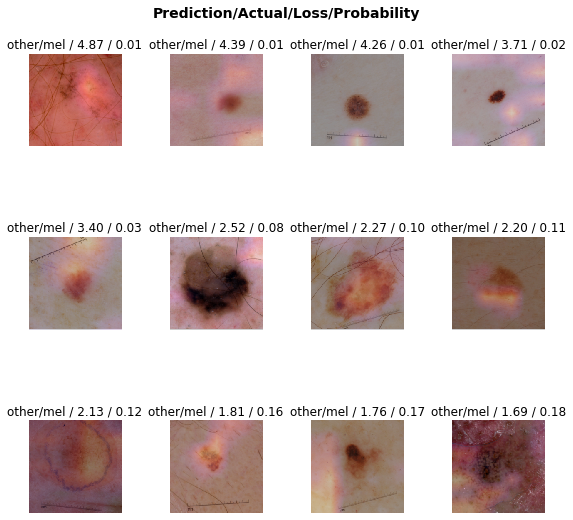

In [25]:
interp.plot_top_losses(12, figsize=(8,8),heatmap=True,alpha=.2)
plt.tight_layout()

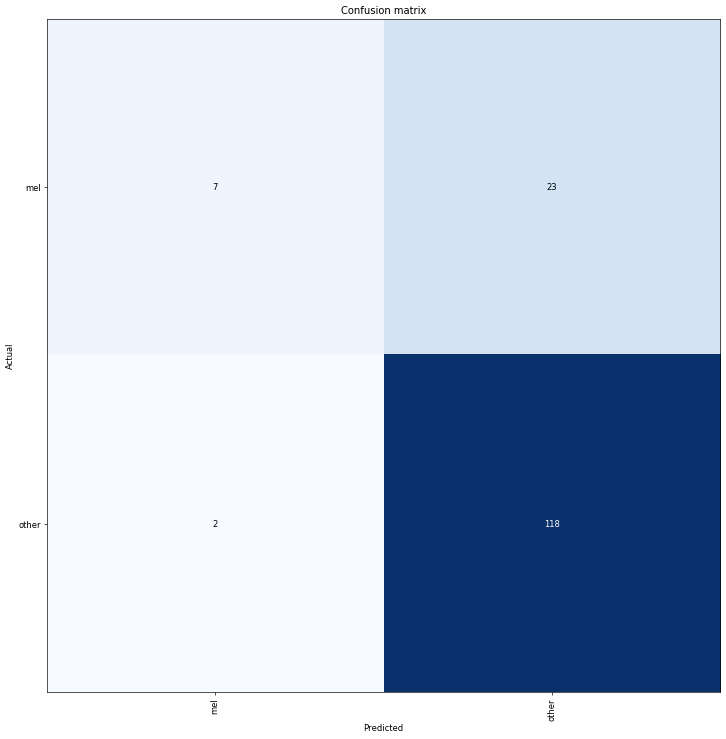

In [20]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
plt.autoscale()

In [94]:

def get_balanced_accurracy(a_confusion_matrix):
  balanced_acc = 0
  for i in range(len(matrix[0])):
    row = matrix[i]
    correctGuesses = row[i]
    allPossibleTries = row.sum()
    classAcurracy = correctGuesses / allPossibleTries
    balanced_acc += classAcurracy
#     print(classAcurracy)
  balanced_acc /= len(matrix[0])
  return balanced_acc



matrix = interp.confusion_matrix()
"average acc: ", get_balanced_accurracy(matrix)


('average acc: ', 0.6583333333333333)

# Attention

In [162]:
from fastai.vision import *

In [163]:
import types

from torchvision.models.resnet import Bottleneck

In [164]:
alpha_initial_value = 0.001

In [165]:
def attn_forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

            
        out = out + (identity * self.softmaxLayer(out) * self.alpha) + (identity)

        out = self.relu(out)

        return out

def add_attn_to_forward_func(a_module):
    a_module.forward = types.MethodType( attn_forward,a_module)
    
def add_attn_params(a_module):
    a_module.softmaxLayer = nn.Softmax2d();
    a_module.alpha = nn.Parameter(torch.ones(1) * alpha_initial_value)
#     print(f'Added attention to {a_module}')
    
    
def change_basic_blocks(a_module):
    if not isinstance(a_module, Bottleneck): return
    add_attn_params(a_module)
    add_attn_to_forward_func(a_module)

In [166]:
resnet50_with_attn = models.resnet50(pretrained=True)
apply_leaf(resnet50_with_attn, change_basic_blocks)

In [167]:
a = list(resnet50_with_attn.modules())[0]

bn = a.layer1[0]

assert bn.alpha.requires_grad

In [168]:
ps = list(resnet50_with_attn.named_parameters())

ls = [n for n in ps if 'alpha' in n[0]]

len(ls)

16

In [169]:
def mock_arch_init(params): 
  return resnet50_with_attn

In [172]:
bottlenecks = [bn for bn in learn.model.modules() if isinstance(bn,Bottleneck)]

In [101]:
class Alphas(ActivationStats):

    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return m.alpha.item(),m.alpha.item()
    

In [173]:
random_seed(7,True)
# x50 = lambda x: xresnet50()
learn = cnn_learner(data,mock_arch_init, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
#                             ActivationStats,
                            partial(Alphas, modules=bottlenecks)
                                  ], 
                    pretrained=True #Is pretrained so alpha dont require grand and net isnt reinitialized
                    )

In [174]:
a = list(resnet50_with_attn.modules())[0]

bn = a.layer1[0]

assert not bn.alpha.requires_grad

In [100]:
bottlenecks[0].alpha.item()

0.0010482196230441332

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.141454,0.796564,0.186667,0.813333,0.685000,00:17
1,0.615271,0.580865,0.186667,0.813333,0.791944,00:17
2,0.516403,0.586867,0.213333,0.786667,0.626389,00:17
3,0.438433,0.410472,0.166667,0.833333,0.804444,00:17
4,0.397942,0.425330,0.173333,0.826667,0.803889,00:17


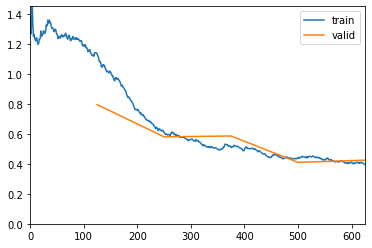

Better model found at epoch 0 with valid_loss value: 0.7965644598007202.
Better model found at epoch 1 with valid_loss value: 0.5808651447296143.
Better model found at epoch 3 with valid_loss value: 0.41047221422195435.


In [120]:
random_seed(7,True)
learn.fit_one_cycle(5,max_lr=3e-3, callbacks = [
    SaveModelCallback(learn=learn),
#     ReduceLROnPlateauCallback(learn=learn)
])

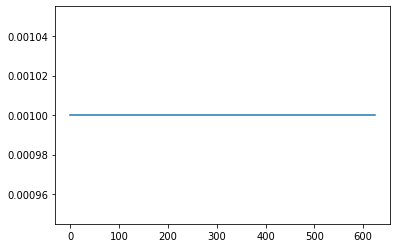

In [128]:
plt.plot(learn.alphas.stats.permute(2,1,0)[0][1])

In [129]:
learn.save('stage-1-with-attn')

In [ ]:
learn.load('stage-1-with-attn')

In [177]:
assert not bn.alpha.requires_grad

In [178]:
learn.unfreeze()

In [179]:
assert bn.alpha.requires_grad

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.256993,0.628362,0.313333,0.686667,0.703333,00:23
1,1.096425,0.580627,0.260000,0.740000,0.700278,00:23
2,0.996303,0.641384,0.306667,0.693333,0.700278,00:23
3,0.803314,0.569850,0.240000,0.760000,0.739167,00:23
4,0.753721,0.565467,0.226667,0.773333,0.746111,00:23
5,0.703138,0.643223,0.180000,0.820000,0.669167,00:24
6,0.646470,0.565845,0.180000,0.820000,0.749167,00:23
7,0.588697,0.516197,0.206667,0.793333,0.716111,00:23
8,0.495621,0.504371,0.180000,0.820000,0.733333,00:23
9,0.468396,0.509248,0.193333,0.806667,0.741111,00:23


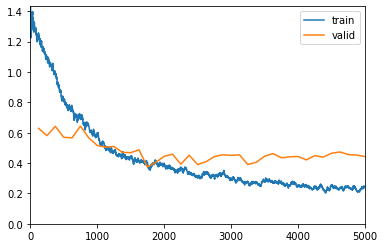

Better model found at epoch 0 with valid_loss value: 0.6283619999885559.
Better model found at epoch 1 with valid_loss value: 0.5806270837783813.
Better model found at epoch 3 with valid_loss value: 0.5698502063751221.
Better model found at epoch 4 with valid_loss value: 0.565467357635498.
Better model found at epoch 7 with valid_loss value: 0.5161969065666199.
Better model found at epoch 8 with valid_loss value: 0.504371166229248.
Better model found at epoch 10 with valid_loss value: 0.47071516513824463.
Better model found at epoch 11 with valid_loss value: 0.46808725595474243.
Better model found at epoch 13 with valid_loss value: 0.37408560514450073.


In [180]:
random_seed(7,True)
learn.fit_one_cycle(40, wd=1e-06, max_lr=slice(1e-05,1e-03),callbacks = [
    SaveModelCallback(learn=learn),
#     ReduceLROnPlateauCallback(learn=learn)
])

In [193]:
learn.export('86auc_40epochs')

/home/mike/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mike/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mike/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mike/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__nam

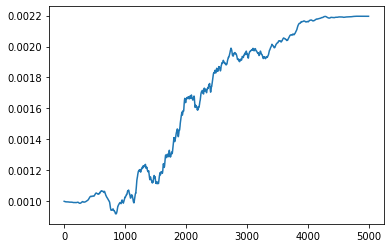

In [189]:
plt.plot(learn.alphas.stats.permute(2,1,0)[0][1])

In [87]:
bn = learn.model[0][4][0]

In [91]:
isinstance(bn,nn.Module)

True

In [57]:
[print(n,"\n") for n in ps if 'alpha' in n[0]]

('layer1.0.alpha', Parameter containing:
tensor([0.0010], device='cuda:0', requires_grad=True)) 

('layer1.1.alpha', Parameter containing:
tensor([0.0012], device='cuda:0', requires_grad=True)) 

('layer1.2.alpha', Parameter containing:
tensor([0.0011], device='cuda:0', requires_grad=True)) 

('layer2.0.alpha', Parameter containing:
tensor([0.0009], device='cuda:0', requires_grad=True)) 

('layer2.1.alpha', Parameter containing:
tensor([0.0016], device='cuda:0', requires_grad=True)) 

('layer2.2.alpha', Parameter containing:
tensor([0.0017], device='cuda:0', requires_grad=True)) 

('layer2.3.alpha', Parameter containing:
tensor([0.0009], device='cuda:0', requires_grad=True)) 

('layer3.0.alpha', Parameter containing:
tensor([0.0024], device='cuda:0', requires_grad=True)) 

('layer3.1.alpha', Parameter containing:
tensor([0.0017], device='cuda:0', requires_grad=True)) 

('layer3.2.alpha', Parameter containing:
tensor([0.0032], device='cuda:0', requires_grad=True)) 

('layer3.3.alpha', P

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

# Mish

In [15]:
from fastai.vision import *

import types

from torchvision.models.resnet import Bottleneck

def mish_forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = out * self.mish1gate * torch.tanh(F.softplus(out))

        out = self.conv2(out)
        out = self.bn2(out)
        out = out * self.mish2gate * torch.tanh(F.softplus(out))

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

            
        out = out + identity

        out = out * self.mish3gate * torch.tanh(F.softplus(out))

        return out

def add_mish_to_forward_func(a_module):
    a_module.forward = types.MethodType( mish_forward, a_module)
    
def add_mish_params(a_module):
    print(f'Adding mish to {a_module}')
    a_module.mish1gate = nn.Parameter(torch.ones(1))
    a_module.mish2gate = nn.Parameter(torch.ones(1))
    a_module.mish3gate = nn.Parameter(torch.ones(1))
    del a_module.relu
    
def change_basic_blocks(a_module):
    if not isinstance(a_module, Bottleneck): return
    add_mish_params(a_module)
    add_mish_to_forward_func(a_module)


In [16]:

resnet50_with_mish = models.resnet50(pretrained=True)
apply_leaf(resnet50_with_mish, change_basic_blocks)


Adding mish to Bottleneck(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Adding mish to Bottleneck(
  (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(

In [17]:
a = list(resnet50_with_mish.modules())[0]

In [18]:
bn = a.layer1[0]

In [19]:
bn.mish1gate

Parameter containing:
tensor([1.], requires_grad=True)

In [20]:
ps = list(resnet50_with_mish.named_parameters())

In [21]:
def mock_arch_init_with_mish(params): 
  return resnet50_with_mish

In [22]:
random_seed(7,True)
# x50 = lambda x: xresnet50()resnet14
learn = cnn_learner(data,mock_arch_init_with_mish, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ], 
                    
                    )

In [168]:
# del learn
# del data

torch.cuda.empty_cache()
gc.collect()

4871

In [169]:
# learn.load('bestmodel')
# learn.lr_find()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.034770,0.907279,0.286667,0.713333,0.515556,00:22
1,0.674582,0.569539,0.206667,0.793333,0.621667,00:22
2,0.570364,0.529503,0.206667,0.793333,0.635833,00:22
3,0.492822,0.457699,0.180000,0.820000,0.745000,00:21
4,0.453891,0.440586,0.186667,0.813333,0.751944,00:21


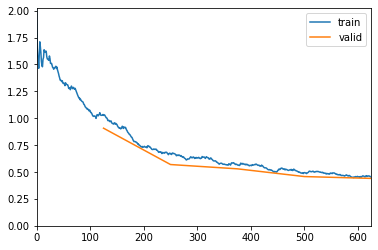

Better model found at epoch 0 with valid_loss value: 0.9072790741920471.
Better model found at epoch 1 with valid_loss value: 0.5695388913154602.
Better model found at epoch 2 with valid_loss value: 0.5295027494430542.
Better model found at epoch 3 with valid_loss value: 0.4576985239982605.
Better model found at epoch 4 with valid_loss value: 0.44058552384376526.


In [170]:
random_seed(7,True)
learn.fit_one_cycle(5,max_lr=3e-3, callbacks = [
    SaveModelCallback(learn=learn),
#     ReduceLROnPlateauCallback(learn=learn)
])

In [171]:
learn.save('stage-1-with-mish')

In [ ]:
learn.load('stage-1-with-mish')

In [24]:
a = list(resnet50_with_mish.modules())[0]

bn = a.layer1[0]

In [25]:
assert not bn.mish1gate.requires_grad

In [26]:
learn.unfreeze()

In [27]:
assert bn.mish1gate.requires_grad

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.390454,0.443938,0.173333,0.826667,0.765833,00:30
1,0.306508,0.493680,0.213333,0.786667,0.703889,00:27
2,0.277540,0.660648,0.226667,0.773333,0.641111,00:27
3,0.376120,0.552073,0.186667,0.813333,0.708333,00:27
4,0.470883,0.537421,0.206667,0.793333,0.710833,00:28
5,0.476074,0.458558,0.180000,0.820000,0.761945,00:27
6,0.437211,0.487816,0.166667,0.833333,0.741667,00:27
7,0.451340,0.443960,0.180000,0.820000,0.769167,00:28
8,0.410526,0.445640,0.180000,0.820000,0.780278,00:28
9,0.419920,0.432835,0.180000,0.820000,0.784722,00:28


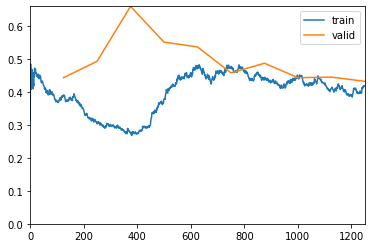

Better model found at epoch 0 with valid_loss value: 0.44393807649612427.
Better model found at epoch 9 with valid_loss value: 0.43283534049987793.


In [28]:
random_seed(7,True)
learn.fit_one_cycle(10, wd=1e-06, max_lr=slice(1e-05,1e-03),callbacks = [
    SaveModelCallback(learn=learn),
#     ReduceLROnPlateauCallback(learn=learn)
])

In [29]:
[print(n,"\n") for n in ps if 'mish' in n[0]]

('layer1.0.mish1gate', Parameter containing:
tensor([1.0001], device='cuda:0', requires_grad=True)) 

('layer1.0.mish2gate', Parameter containing:
tensor([0.9995], device='cuda:0', requires_grad=True)) 

('layer1.0.mish3gate', Parameter containing:
tensor([0.9998], device='cuda:0', requires_grad=True)) 

('layer1.1.mish1gate', Parameter containing:
tensor([1.0002], device='cuda:0', requires_grad=True)) 

('layer1.1.mish2gate', Parameter containing:
tensor([0.9998], device='cuda:0', requires_grad=True)) 

('layer1.1.mish3gate', Parameter containing:
tensor([1.0000], device='cuda:0', requires_grad=True)) 

('layer1.2.mish1gate', Parameter containing:
tensor([1.0002], device='cuda:0', requires_grad=True)) 

('layer1.2.mish2gate', Parameter containing:
tensor([1.0002], device='cuda:0', requires_grad=True)) 

('layer1.2.mish3gate', Parameter containing:
tensor([0.9993], device='cuda:0', requires_grad=True)) 

('layer2.0.mish1gate', Parameter containing:
tensor([1.0003], device='cuda:0', req

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]